# 1. Generate synthetic data with CTGAN

## Load Library

- Library for data type

In [1]:
import pandas as pd
import numpy as np

- Library for model trainning 
- Use torch to facilitate computation using GPU

In [2]:
import torch
#Tools for Python Memory Management
import gc 
from ctgan import CTGAN

C:\Users\0614_\anaconda3\envs\wco_ctgan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Check we can use GPU(with cuda)

In [3]:
torch.cuda.is_available()

True

In [4]:
# Manually turn off objects that are not currently needed
gc.collect()
# Function to clear the CUDA memory cache curently in use
torch.cuda.empty_cache()

- Library for graphing

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

- setting etc 

In [6]:
import copy
import time

from collections import defaultdict
from itertools import islice, combinations
from datetime import datetime as dt

import warnings
warnings.filterwarnings("ignore")

- setting Jupyter Notebook

In [7]:
#Jupiter Cell Full Screen View
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# useful for debuging (print the results of both formulas and functions entered in one cell of Jupiter)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
# Each column width at maximum (print all column contents)
pd.set_option('display.max_colwidth', -1)
# Show up to 500 rows
pd.set_option('display.max_rows', 500)
# Display up to 500 columns
pd.set_option('display.max_columns', 500)
# Total length of data frame
pd.set_option('display.width', 1000)

print('ready to run')
# logging starttime 
startTime = time.time()

ready to run


## Load Data

In [8]:
df_raw=pd.read_csv('df_syn_en.csv', encoding='utf-8-sig')

## Data copy

In [9]:
df_raw_copy = copy.deepcopy(df_raw)

## Check the data
- 'dec_num' deduplication (unique value)
- Sorting by 'dec_date' (ASC)
- Check for outliers ('imp_dec_code')

In [10]:
#Change of 'dec_date' type
df_raw_copy['dec_date'] = pd.to_datetime(df_raw_copy['dec_date']) 
#'dec_num' deduplication
df_org = df_raw_copy.drop_duplicates(['dec_num'], keep = 'first') 
#'dec_date' sorting ASC
df_org = df_org.sort_values(by = ['dec_date'], axis = 0) 

In [11]:
df_org.shape

(54000, 22)

In [12]:
df_org.head()

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
0,97061800,2020-01-01,30,B,11,21,11,10,ZZR1LT6,QLRUBN9,0VKY2BR,NaN,4408909195,BE,BE,0.0,FEU1,G,108.0,372254.40,0,0
25,21073696,2020-01-01,70,B,11,21,11,10,0M7YBNH,55BH1VM,OOZO637,NaN,9206009000,NP,NP,0.0,R,S,60.0,3486.00,0,0
23,64705381,2020-01-01,30,B,11,21,11,10,CSYO98C,Y3QS787,KQ8UJP7,NaN,7326909000,DE,DE,0.0,FEU1,Y,22.0,33.00,0,0
22,25886903,2020-01-01,20,B,11,21,11,10,5K1441H,EHXQG9A,W3K0JC6,NaN,8517623900,CA,CA,0.0,CIT,Y,14.1,13320.27,0,0
21,19201172,2020-01-01,40,B,11,21,11,10,A7POIBB,Q8MAKJD,KILND1W,NaN,2005999000,CN,CN,18.0,FCN1,G,48320.0,4575904.00,0,0


In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dec_num                 54000 non-null  int64         
 1   dec_date                54000 non-null  datetime64[ns]
 2   dec_custom_code         54000 non-null  int64         
 3   imp_dec_code            54000 non-null  object        
 4   imp_trd_code            54000 non-null  int64         
 5   imp_typ_code            54000 non-null  int64         
 6   collect_code            54000 non-null  int64         
 7   typ_transport_code      54000 non-null  int64         
 8   dec_mark                54000 non-null  object        
 9   importer                54000 non-null  object        
 10  ovs_cust_code           48799 non-null  object        
 11  exps_carr_code          9538 non-null   object        
 12  HS10                    54000 non-null  int64 

In [14]:
df_org.describe(include = 'all')

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
count,5.400000e+04,54000,54000.000000,54000,54000.000000,54000.000000,54000.000000,54000.000000,54000,54000,48799,9538,5.400000e+04,54000,54000,54000.000000,54000,54000,5.400000e+04,5.400000e+04,54000.000000,54000.000000
unique,NaN,547,NaN,3,NaN,NaN,NaN,NaN,1238,14482,12201,81,NaN,102,119,NaN,49,6,NaN,NaN,NaN,NaN
top,NaN,2021-02-01 00:00:00,NaN,B,NaN,NaN,NaN,NaN,DWNJQL8,708A72F,7PN0VA5,MWIDNS,NaN,CN,CN,NaN,A,E,NaN,NaN,NaN,NaN
freq,NaN,505,NaN,53992,NaN,NaN,NaN,NaN,1777,196,271,3109,NaN,24956,27486,NaN,20367,15269,NaN,NaN,NaN,NaN
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2021-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.507171e+07,NaN,31.227241,NaN,19.554000,20.666093,17.532352,23.166111,NaN,NaN,NaN,NaN,6.172031e+09,NaN,NaN,7.430657,NaN,NaN,2.674132e+04,3.512241e+06,0.215796,0.225889
std,2.596503e+07,NaN,16.053572,NaN,24.107826,2.393293,12.319247,15.378693,NaN,NaN,NaN,NaN,2.615394e+09,NaN,NaN,26.708652,NaN,NaN,6.659435e+05,5.405280e+07,0.411377,0.441647
min,1.000019e+07,NaN,10.000000,NaN,11.000000,11.000000,0.000000,10.000000,NaN,NaN,NaN,NaN,1.012910e+08,NaN,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.256710e+07,NaN,20.000000,NaN,11.000000,21.000000,11.000000,10.000000,NaN,NaN,NaN,NaN,3.926909e+09,NaN,NaN,0.000000,NaN,NaN,9.400000e+00,5.071350e+02,0.000000,0.000000


### Outlier Found
- Ensure that a particular value is concentrated in one column
- Recognizes that only one value can be biased and extracted during sampling

In [15]:
df_org['imp_dec_code'].value_counts()

B    53992
D    7    
A    1    
Name: imp_dec_code, dtype: int64

### Check the correlation
- Correlate with other columns to see what features it have
- Ensure no particular correlation is shown
- Work proceeds without further action

- Working with encoding data frames as numeric data

In [16]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for column_name,item in df_raw_copy.iteritems(): 
    encoder.fit(item)
    labels = encoder.transform(item)
    df_raw_copy[column_name] = labels

In [17]:
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Arial'

def set_font():
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=12)
    return fontprop

fontprop = set_font()

In [18]:
corr = df_raw_copy.corr()

<AxesSubplot: >

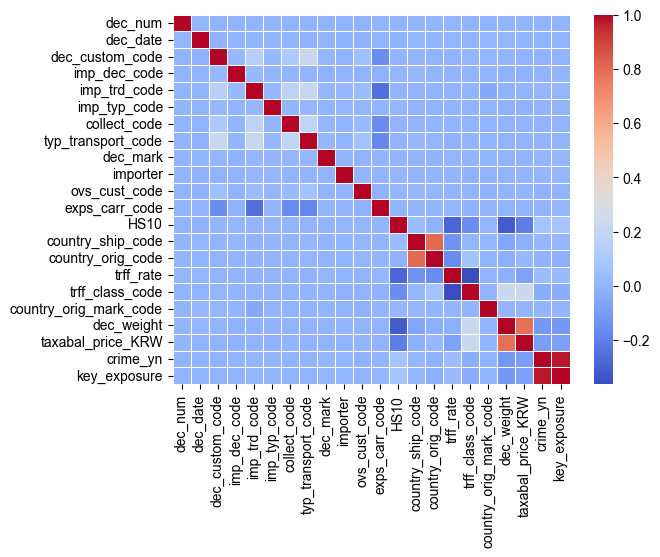

In [19]:
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths =0.5, annot_kws={'size':10, 'fontproperties':fontprop},vmin=-1.0)

## Random data sampling 
- This exercise is performed with no more than 2000 samples in a 6GB VRAM environment

In [20]:
df_sample=df_org.sample(1500,replace=False)
df_sample_raw=df_org.sample(1500,replace=False)

## 샘플 데이터 처리

- Preserve correlation by grouping well-correlated columns into a single multiple column
- Correlation may not be preserved during data generation

In [21]:
cols = ['HS10', 'country_ship_code', 'country_orig_code', 'trff_rate', 'trff_class_code', 'dec_weight','taxabal_price_KRW','crime_yn', 'key_exposure']
df_sample['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'] = df_sample[cols].apply(lambda row: '^'.join(row.values.astype(str)), axis=1)

### 불필요한 칼럼 삭제
- Delete Duplicate Columns

In [22]:
df_sample=df_sample.drop(cols, axis=1)

## Trainning model with CTGAN 

In [23]:
torch.no_grad()

In [24]:
categorical_columns =[ 'dec_num', 'dec_date','dec_custom_code','imp_dec_code','imp_trd_code',\
                      'imp_typ_code','collect_code', 'typ_transport_code','dec_mark','importer',\
                      'ovs_cust_code','exps_carr_code','country_orig_mark_code','HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key']

In [25]:
ctgan = CTGAN(verbose=True)
startTime = time.time()
ctgan.fit(df_sample, categorical_columns, epochs = 600)
endTime = time.time()

print('time:', endTime - startTime )

Epoch 1, Loss G:  4.2516,Loss D: -0.0498
Epoch 2, Loss G:  4.2765,Loss D: -0.1806
Epoch 3, Loss G:  4.0445,Loss D: -0.2794
Epoch 4, Loss G:  4.2768,Loss D: -0.4169
Epoch 5, Loss G:  4.3037,Loss D: -0.5104
Epoch 6, Loss G:  4.1700,Loss D: -0.6236
Epoch 7, Loss G:  4.2527,Loss D: -0.6716
Epoch 8, Loss G:  4.3987,Loss D: -0.8477
Epoch 9, Loss G:  4.2445,Loss D: -0.9933
Epoch 10, Loss G:  4.4729,Loss D: -1.0040
Epoch 11, Loss G:  4.4371,Loss D: -1.0407
Epoch 12, Loss G:  4.3537,Loss D: -1.1408
Epoch 13, Loss G:  3.9112,Loss D: -1.0447
Epoch 14, Loss G:  3.5088,Loss D: -0.7879
Epoch 15, Loss G:  3.7047,Loss D: -0.6979
Epoch 16, Loss G:  3.5202,Loss D: -0.5954
Epoch 17, Loss G:  3.5065,Loss D: -0.5831
Epoch 18, Loss G:  3.4360,Loss D: -0.4348
Epoch 19, Loss G:  3.3567,Loss D: -0.2884
Epoch 20, Loss G:  3.3348,Loss D: -0.0824
Epoch 21, Loss G:  3.1719,Loss D: -0.1740
Epoch 22, Loss G:  3.3260,Loss D: -0.0170
Epoch 23, Loss G:  3.0817,Loss D: -0.1700
Epoch 24, Loss G:  3.0481,Loss D: -0.1628
E

## Generating synthetic data with trained model

In [43]:
df_syn = ctgan.sample(len(df_sample))

In [44]:
df_syn = df_syn.sort_values('dec_num')

## Save the new data

In [45]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 456 to 1396
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   dec_num                                               1500 non-null   int64         
 1   dec_date                                              1500 non-null   datetime64[ns]
 2   dec_custom_code                                       1500 non-null   int64         
 3   imp_dec_code                                          1500 non-null   object        
 4   imp_trd_code                                          1500 non-null   int64         
 5   imp_typ_code                                          1500 non-null   int64         
 6   collect_code                                          1500 non-null   int64         
 7   typ_transport_code                                    1500 non-null   int64 

In [46]:
df_syn['HS10']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[0]
df_syn['country_ship_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[1]
df_syn['country_orig_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[2]
df_syn['trff_rate']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[3]
df_syn['trff_class_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[4]
df_syn['dec_weight']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[5]
df_syn['taxabal_price_KRW']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[6]
df_syn['crime_yn']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[7]
df_syn['key_exposure']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[8]

In [47]:
df_syn = df_syn.drop(['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'],axis=1)

- Sort columns the same as the original data

In [48]:
df_tmp = df_syn[['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure']]
df_syn = df_syn.drop(['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure'],axis=1)
df_syn = pd.concat([df_syn, df_tmp], axis = 1)

In [49]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 456 to 1396
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dec_num                 1500 non-null   int64         
 1   dec_date                1500 non-null   datetime64[ns]
 2   dec_custom_code         1500 non-null   int64         
 3   imp_dec_code            1500 non-null   object        
 4   imp_trd_code            1500 non-null   int64         
 5   imp_typ_code            1500 non-null   int64         
 6   collect_code            1500 non-null   int64         
 7   typ_transport_code      1500 non-null   int64         
 8   dec_mark                1500 non-null   object        
 9   importer                1500 non-null   object        
 10  ovs_cust_code           1451 non-null   object        
 11  exps_carr_code          286 non-null    object        
 12  HS10                    1500 non-null   object

In [50]:
df_syn.to_csv('./data_sample/df_syn_en_14.csv', index=False, encoding='utf-8-sig')